In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16

# Classification of Song Clip Genres from Spectrograms

For the final project for CS345 I have decied to attempt to classify the spectrograms of a song into its genre using a Convolutional Neural Network.

 The dataset chosen for this project is made from 100 different thirty second clips of songs from ten different genres. The dataset contains the orignial sound file, a spectrogram made from the song, and then a csv made up of numerical data collected on the song.

 To test whether a CNN classifier is a good choice for this problem I will also train a Random Forest classifier as the baseline.

## Random Forest Classification
I am going to use the data on the 30 second clips to train our basline Random Forsest Model. There was an additional dataset that was made up of 10 seperate data collections for each 30 second clip but to keep the models equivelant we are going to use the original data.

### Loading in the data for Random Forest
This is neccessary to make predictions on the 10 labels. Predictions made are on the integer classes not the strings. 

We are also going to remove the lable and the the filenames from the dataset since they are strings that won't work with the model

In [2]:
# Read in the dataset
data = pd.read_csv("./Data/features_30_sec.csv")

print(data["label"][::100])
encoder = LabelEncoder()
data["label"] = encoder.fit_transform(data["label"])
print(data["label"][::100])
print(data.shape)

# Drop strings from dataset

clean_X = data.drop(["label", "filename", "image_filename"], axis=1)
clean_y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    clean_X, clean_y, test_size=0.2, random_state=101
)
print(X_train.shape)
print(y_train.shape)

0          blues
100    classical
200      country
300        disco
400       hiphop
500         jazz
600        metal
700          pop
800       reggae
900         rock
Name: label, dtype: object
0      0
100    1
200    2
300    3
400    4
500    5
600    6
700    7
800    8
900    9
Name: label, dtype: int64
(1000, 61)
(800, 58)
(800,)


### Train and assess the Random Forest 

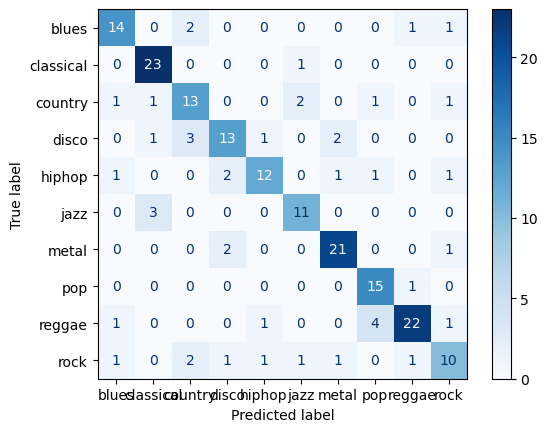

Random Forest average accuracy: 0.77%


In [3]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X=X_train, y=y_train)

y_pred = model.predict(X_test)
baseline_accuracy = np.mean(y_pred == y_test)

labels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=labels
)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(f"Random Forest average accuracy: {baseline_accuracy}%")

### Random Forest Accuracy
Training the Random Forset on the .csv data from the data set we can get an accuracy of around 76.5%. Looking at the confusion matrix we can see a good line down the middle and it seems like rock was the worst genre for the model to predict.

## Convolutional Neural Network Training
To create our CNN newtwork we first need to import the data. The Images are stored as 100 .png files in a directory for each genre. We will need to load these images and possibly randomize the order of them so they aren't seperated by genre.

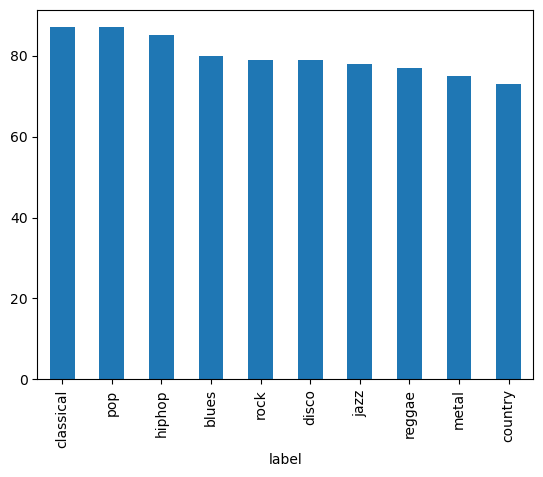

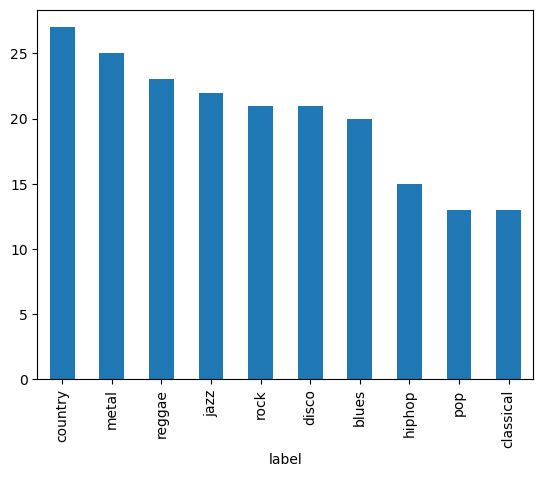

Found 800 validated image filenames belonging to 10 classes.
Found 199 validated image filenames belonging to 10 classes.


/Users/phillipjohnson/anaconda3/envs/IntroML/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image_filename". These filename(s) will be ignored.
  warnings.warn(


In [6]:
import pandas as pd

df = pd.read_csv("./Data/features_30_sec.csv")

image_directory = "./Data/images/"

# print(df['label'])
# print(df.head)

datagen = ImageDataGenerator(rescale=1.0 / 255)

batch = 32

train, test = train_test_split(df, test_size=0.2, random_state=42)

train_count = train["label"].value_counts()
train_count.plot(kind="bar")
plt.show()

test_count = test["label"].value_counts()
test_count.plot(kind="bar")
plt.show()

train_data = datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_directory,
    x_col="image_filename",
    y_col="label",
    target_size=(288, 432),
    color_mode="rgb",
    batch_size=batch,
    class_mode="categorical",
    shuffle=True,
)

test_data = datagen.flow_from_dataframe(
    dataframe=test,
    directory=image_directory,
    x_col="image_filename",
    y_col="label",
    target_size=(288, 432),
    color_mode="rgb",
    batch_size=batch,
    class_mode="categorical",
    shuffle=False,
)

### Missing Jazz
It looks like there are only 99 files in the Jazz directory. I checked the online data and that is also missing one image. It shouldn't be a big issues but I just wanted to note the difference.

### First CNN (Class)
For our first attempt at training the CNN we will use the one from the class notebook

In [7]:
conv_network = tf.keras.Sequential()
conv_network.add(
    tf.keras.layers.Conv2D(
        32,
        (3, 3),
        strides=(2, 2),
        activation="relu",
        input_shape=(288, 432, 3),
        padding="same",
    )
)

conv_network.add(
    tf.keras.layers.Conv2D(
        32, (3, 3), strides=(2, 2), activation="relu", padding="same"
    )
)

conv_network.add(
    tf.keras.layers.Conv2D(
        32, (3, 3), strides=(2, 2), activation="relu", padding="same"
    )
)

conv_network.add(tf.keras.layers.Flatten())

conv_network.add(tf.keras.layers.Dense(100, activation="relu"))
conv_network.add(tf.keras.layers.Dense(10, activation="softmax"))

conv_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 216, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 108, 32)       9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 54, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 62208)             0         
                                                                 
 dense (Dense)               (None, 100)               6220900   
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 6,241,302
Trainable params: 6,241,302
Non-

In [10]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam()

conv_network.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])
history_conv = conv_network.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    verbose=1,
)

Epoch 1/10


2024-05-04 17:24:56.408953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-04 17:24:56.414208: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - ETA: 0s - loss: 2.5511 - accuracy: 0.1262

2024-05-04 17:25:00.458847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 5s 178ms/step - loss: 2.5511 - accuracy: 0.1262 - val_loss: 2.2816 - val_accuracy: 0.1658
Epoch 2/10
25/25 [==============================] - 4s 160ms/step - loss: 2.1602 - accuracy: 0.2250 - val_loss: 2.0188 - val_accuracy: 0.3015
Epoch 3/10
25/25 [==============================] - 4s 162ms/step - loss: 1.7361 - accuracy: 0.4162 - val_loss: 1.6973 - val_accuracy: 0.2915
Epoch 4/10
25/25 [==============================] - 4s 164ms/step - loss: 1.1233 - accuracy: 0.6562 - val_loss: 1.4729 - val_accuracy: 0.4824
Epoch 5/10
25/25 [==============================] - 4s 163ms/step - loss: 0.6278 - accuracy: 0.8025 - val_loss: 1.7842 - val_accuracy: 0.4724
Epoch 6/10
25/25 [==============================] - 4s 164ms/step - loss: 0.2533 - accuracy: 0.9362 - val_loss: 1.5720 - val_accuracy: 0.5327
Epoch 7/10
25/25 [==============================] - 4s 160ms/step - loss: 0.0610 - accuracy: 0.9937 - val_loss: 1.5359 - val_accuracy: 0.5427
Epoch 8/10
25/25 

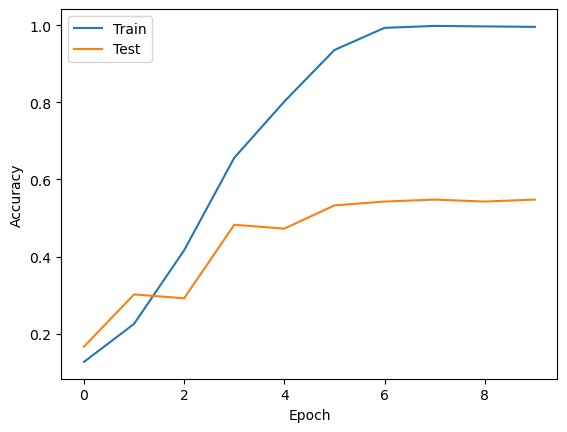

In [12]:
plt.plot(history_conv.history["accuracy"], label="Train")
plt.plot(history_conv.history["val_accuracy"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

1/7 [===>..........................] - ETA: 1s

2024-05-04 17:26:49.348274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 1s 94ms/step


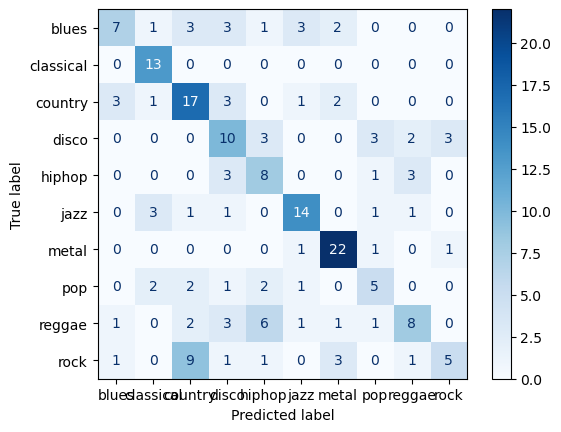

Accuracy:0.5477386934673367


In [11]:
y_pred = conv_network.predict(test_data)
predicted_classes = np.argmax(y_pred, axis=1)
# print(predicted_classes)
true_labels = test_data.classes


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_labels, predicted_classes)

labels = list(test_data.class_indices.keys())


disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(f"Accuracy:{np.mean(predicted_classes==true_labels)}")

### Results from Class CNN
 
After training the CNN on the dataset I got an accuracy of 54.8% with a confusion matrix that has a line going down the diagonal. We can still try to improve this.

### Imagenet CNN


In [20]:
vgg16_model = VGG16(weights="imagenet", include_top=False, input_shape=(288, 432, 3))

for layer in vgg16_model.layers:
    layer.trainable = False

conv_network = tf.keras.Sequential()
conv_network.add(vgg16_model)
conv_network.add(tf.keras.layers.Flatten())
conv_network.add(tf.keras.layers.Dropout(0.5))
conv_network.add(tf.keras.layers.Dense(128, activation="relu"))
conv_network.add(tf.keras.layers.Dense(10, activation="softmax"))

conv_network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 13, 512)        14714688  
                                                                 
 flatten_1 (Flatten)         (None, 59904)             0         
                                                                 
 dropout (Dropout)           (None, 59904)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               7667840   
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 22,383,818
Trainable params: 7,669,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
conv_network.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])
history_conv = conv_network.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    verbose=1,
)

Epoch 1/10


2024-05-04 19:01:08.863452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - ETA: 0s - loss: 4.1830 - accuracy: 0.1350

2024-05-04 19:03:10.574077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 152s 6s/step - loss: 4.1830 - accuracy: 0.1350 - val_loss: 2.2674 - val_accuracy: 0.1005
Epoch 2/10
25/25 [==============================] - 150s 6s/step - loss: 2.0607 - accuracy: 0.2237 - val_loss: 1.9061 - val_accuracy: 0.2915
Epoch 3/10
25/25 [==============================] - 150s 6s/step - loss: 1.8563 - accuracy: 0.3212 - val_loss: 1.7437 - val_accuracy: 0.4070
Epoch 4/10
25/25 [==============================] - 150s 6s/step - loss: 1.6871 - accuracy: 0.4137 - val_loss: 1.6687 - val_accuracy: 0.4070
Epoch 5/10
25/25 [==============================] - 150s 6s/step - loss: 1.5764 - accuracy: 0.4750 - val_loss: 1.6171 - val_accuracy: 0.4623
Epoch 6/10
25/25 [==============================] - 150s 6s/step - loss: 1.4816 - accuracy: 0.4675 - val_loss: 1.5052 - val_accuracy: 0.4975
Epoch 7/10
25/25 [==============================] - 150s 6s/step - loss: 1.3418 - accuracy: 0.5238 - val_loss: 1.4609 - val_accuracy: 0.4824
Epoch 8/10
25/25 [======

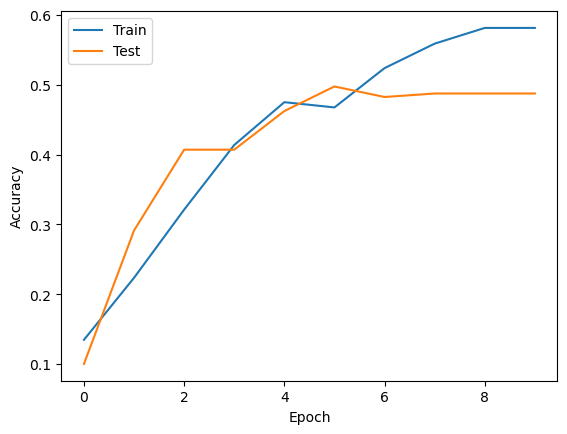

In [22]:
plt.plot(history_conv.history["accuracy"], label="Train")
plt.plot(history_conv.history["val_accuracy"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

2024-05-04 19:27:19.227511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 30s 4s/step


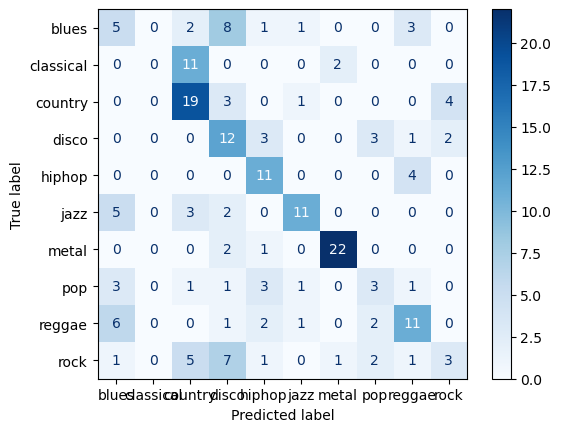

Accuracy:0.48743718592964824


In [23]:
y_pred = conv_network.predict(test_data)
predicted_classes = np.argmax(y_pred, axis=1)
# print(predicted_classes)
true_labels = test_data.classes


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_labels, predicted_classes)

labels = list(test_data.class_indices.keys())


disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(f"Accuracy:{np.mean(predicted_classes==true_labels)}")

### Pretrained accuracy

Running the pretrained model took a long time and the accuracy was not better. This makes sense as the pretrained is trained on general images not something that would help with the specialized features of a spectrogram.

### Improved CNN
To try and improve the CNN I have increased the batch size to 64 to see if that improves the accuracy. I have also added max pooling and a dropout layer to help with overfitting.

In [25]:
batch = 64

train_data = datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_directory,
    x_col="image_filename",
    y_col="label",
    target_size=(288, 432),
    color_mode="rgb",
    batch_size=batch,
    class_mode="categorical",
    shuffle=True,
)

test_data = datagen.flow_from_dataframe(
    dataframe=test,
    directory=image_directory,
    x_col="image_filename",
    y_col="label",
    target_size=(288, 432),
    color_mode="rgb",
    batch_size=batch,
    class_mode="categorical",
    shuffle=False,
)

conv_network = tf.keras.Sequential()
conv_network.add(
    tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        input_shape=(288, 432, 3),
    )
)
conv_network.add(tf.keras.layers.MaxPooling2D((2, 2)))

conv_network.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
conv_network.add(tf.keras.layers.MaxPooling2D((2, 2)))

conv_network.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
conv_network.add(tf.keras.layers.MaxPooling2D((2, 2)))

conv_network.add(tf.keras.layers.Flatten())
conv_network.add(tf.keras.layers.Dropout(0.5))

conv_network.add(tf.keras.layers.Dense(256, activation="relu"))
conv_network.add(tf.keras.layers.Dense(10, activation="softmax"))

conv_network.summary()

Found 800 validated image filenames belonging to 10 classes.
Found 199 validated image filenames belonging to 10 classes.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 286, 430, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 143, 215, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 141, 213, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 70, 106, 64)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 68, 104, 128)      73856    

/Users/phillipjohnson/anaconda3/envs/IntroML/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image_filename". These filename(s) will be ignored.
  warnings.warn(


In [26]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam()

checkpoint = ModelCheckpoint(
    "coen.keras", monitor="val_loss", verbose=1, save_best_only=True
)

conv_network.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])
history_conv = conv_network.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[checkpoint],
)

2024-05-04 20:13:09.119999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 4.0162 - accuracy: 0.1388

2024-05-04 20:13:31.889127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.22082, saving model to coen.keras
13/13 [==============================] - 25s 2s/step - loss: 4.0162 - accuracy: 0.1388 - val_loss: 2.2208 - val_accuracy: 0.1809
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 2.1507 - accuracy: 0.2212
Epoch 2: val_loss improved from 2.22082 to 2.04370, saving model to coen.keras
13/13 [==============================] - 25s 2s/step - loss: 2.1507 - accuracy: 0.2212 - val_loss: 2.0437 - val_accuracy: 0.2462
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 1.8882 - accuracy: 0.3288
Epoch 3: val_loss improved from 2.04370 to 1.84762, saving model to coen.keras
13/13 [==============================] - 25s 2s/step - loss: 1.8882 - accuracy: 0.3288 - val_loss: 1.8476 - val_accuracy: 0.3317
Epoch 4/20
13/13 [==============================] - ETA: 0s - loss: 1.6185 - accuracy: 0.4500
Epoch 4: val_loss improved from 1.84762 to 1.69409, saving model to coen.keras
13/13 [===========

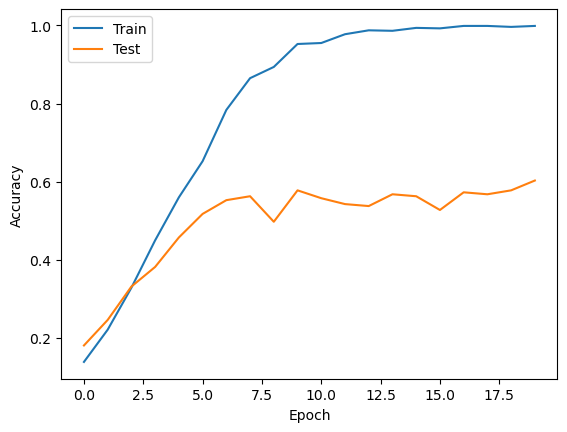

In [27]:
plt.plot(history_conv.history["accuracy"], label="Train")
plt.plot(history_conv.history["val_accuracy"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

2024-05-04 20:23:04.985039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 2s 368ms/step


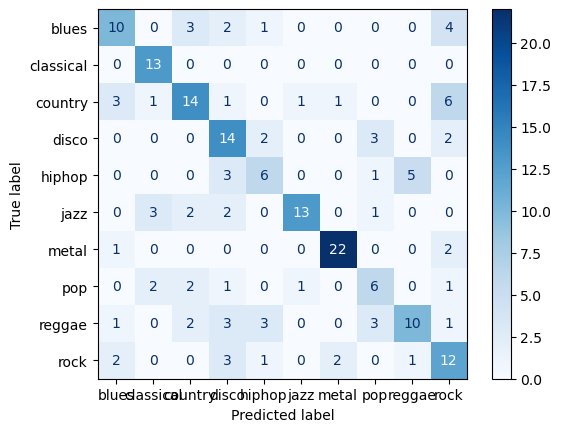

Accuracy:0.6030150753768844


In [28]:
y_pred = conv_network.predict(test_data)
predicted_classes = np.argmax(y_pred, axis=1)
# print(predicted_classes)
true_labels = test_data.classes


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_labels, predicted_classes)

labels = list(test_data.class_indices.keys())


disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(f"Accuracy:{np.mean(predicted_classes==true_labels)}")

### Improved CNN Accuracy
Looking at the results of this CNN we see that it is the most accurate but there seems to be a problem with overfitting the training data. We get a training accuracy of 99.9% however we can only get a testing accuracy of 60.3%. 

To try and help with this I want to try and use image augmentation.
### Data Augmentation

In [55]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.2, 1.5],
)

batch = 64

train_data = datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_directory,
    x_col="image_filename",
    y_col="label",
    target_size=(288, 432),
    color_mode="rgb",
    batch_size=batch,
    class_mode="categorical",
    shuffle=True,
)

test_data = datagen.flow_from_dataframe(
    dataframe=test,
    directory=image_directory,
    x_col="image_filename",
    y_col="label",
    target_size=(288, 432),
    color_mode="rgb",
    batch_size=batch,
    class_mode="categorical",
    shuffle=False,
)

conv_network = tf.keras.Sequential()
conv_network.add(
    tf.keras.layers.Conv2D(
        32,
        (7, 7),
        activation="relu",
        input_shape=(288, 432, 3),
    )
)
conv_network.add(tf.keras.layers.MaxPooling2D((2, 2)))

conv_network.add(tf.keras.layers.Conv2D(64, (5, 5), activation="relu"))
conv_network.add(tf.keras.layers.MaxPooling2D((2, 2)))

conv_network.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
conv_network.add(tf.keras.layers.MaxPooling2D((2, 2)))

conv_network.add(tf.keras.layers.Flatten())
conv_network.add(tf.keras.layers.Dropout(0.5))

conv_network.add(tf.keras.layers.Dense(256, activation="relu"))
conv_network.add(tf.keras.layers.Dense(10, activation="softmax"))

conv_network.summary()

Found 800 validated image filenames belonging to 10 classes.
Found 199 validated image filenames belonging to 10 classes.
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 282, 426, 32)      4736      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 141, 213, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 137, 209, 64)      51264     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 68, 104, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 66, 102, 128)      73856   

/Users/phillipjohnson/anaconda3/envs/IntroML/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image_filename". These filename(s) will be ignored.
  warnings.warn(


In [56]:
checkpoint = ModelCheckpoint(
    "coen.keras", monitor="val_loss", verbose=1, save_best_only=True
)

conv_network.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])
history_conv = conv_network.fit(
    train_data,
    validation_data=test_data,
    epochs=32,
    callbacks=[checkpoint],
)

Epoch 1/32


2024-05-04 22:11:26.501985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - ETA: 0s - loss: 3.1468 - accuracy: 0.1000

2024-05-04 22:12:23.427351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.30428, saving model to coen.keras
13/13 [==============================] - 62s 5s/step - loss: 3.1468 - accuracy: 0.1000 - val_loss: 2.3043 - val_accuracy: 0.0854
Epoch 2/32
13/13 [==============================] - ETA: 0s - loss: 2.2762 - accuracy: 0.1637
Epoch 2: val_loss improved from 2.30428 to 2.22493, saving model to coen.keras
13/13 [==============================] - 61s 5s/step - loss: 2.2762 - accuracy: 0.1637 - val_loss: 2.2249 - val_accuracy: 0.1910
Epoch 3/32
13/13 [==============================] - ETA: 0s - loss: 2.1733 - accuracy: 0.2013
Epoch 3: val_loss improved from 2.22493 to 2.14490, saving model to coen.keras
13/13 [==============================] - 60s 5s/step - loss: 2.1733 - accuracy: 0.2013 - val_loss: 2.1449 - val_accuracy: 0.2513
Epoch 4/32
13/13 [==============================] - ETA: 0s - loss: 2.1304 - accuracy: 0.2237
Epoch 4: val_loss improved from 2.14490 to 2.05492, saving model to coen.keras
13/13 [===========

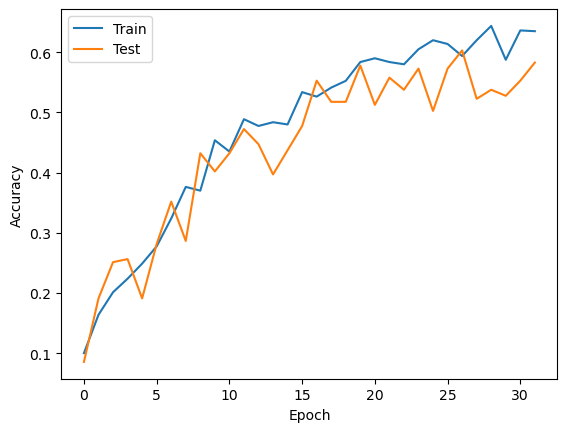

In [57]:
plt.plot(history_conv.history["accuracy"], label="Train")
plt.plot(history_conv.history["val_accuracy"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

2024-05-04 22:43:52.943154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 5s 937ms/step


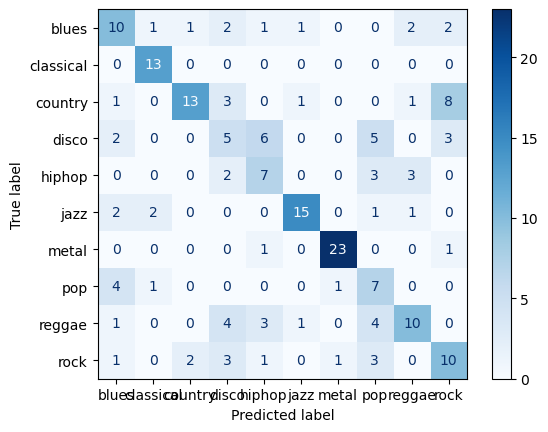

Accuracy:0.5678391959798995


In [58]:
y_pred = conv_network.predict(test_data)
predicted_classes = np.argmax(y_pred, axis=1)
# print(predicted_classes)
true_labels = test_data.classes


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_labels, predicted_classes)

labels = list(test_data.class_indices.keys())


disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(f"Accuracy:{np.mean(predicted_classes==true_labels)}")

### Data Augmentation Accuracy

After trying to add some data augmentation to the dataset there isn't a noticable improvement in the accuarcy of the model.

# Conclusion
After trying to train a few CNN classification models it seems like the dataset is not appropriate for a CNN. The issue could be with the amount of song samples or the resolution of the spectrograms. It could also be that there are too many classes for the model to classify. A random classificaiton for a sample into one of ten classes is 10%. considering that the CNN performs decently well. It does not do as well as the Random Forest baseline.

I tried to leave the optimization of the CNN to my teammate but he was unresponsive throughout the whole project. With more time I might have been able to find a CNN that could more accurately classify the genre of a song's spectrogram.